In [45]:
# import libraries

import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
def fetch_crypto_data(coin_id, days, currency='cad'):
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    params = {'vs_currency': currency, 'days': days}
    response = requests.get(url, params=params)
    data = response.json()
    if 'prices' in data:
        df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
        df['high'] = pd.DataFrame(data['prices'])[1].rolling(window=1, center=True).max()
        df['low'] = pd.DataFrame(data['prices'])[1].rolling(window=1, center=True).min()
        df['volume'] = pd.DataFrame(data['total_volumes'], columns=['timestamp', 'volume'])['volume']
        df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('date', inplace=True)
        df.reset_index('date', inplace=True)
        return df
    else:
        return None

cryptos = ['bitcoin', 'ethereum', 'dogecoin']
data = {}
for crypto in cryptos:
    data[crypto] = fetch_crypto_data(crypto, 365)

In [28]:
data['bitcoin']

,date,timestamp,price,high,low,volume
0,2023-09-06 00:00:00,1693958400000,35167.206893,35167.206893,35167.206893,1.041161e+10
1,2023-09-07 00:00:00,1694044800000,35126.648989,35126.648989,35126.648989,1.667530e+10
2,2023-09-08 00:00:00,1694131200000,35845.910805,35845.910805,35845.910805,6.188648e+09
3,2023-09-09 00:00:00,1694217600000,35380.206106,35380.206106,35380.206106,1.100549e+10
4,2023-09-10 00:00:00,1694304000000,35363.523497,35363.523497,35363.523497,5.529453e+08
...,...,...,...,...,...,...
361,2024-09-01 00:00:00,1725148800000,79581.579333,79581.579333,79581.579333,1.538592e+10
362,2024-09-02 00:00:00,1725235200000,77378.427003,77378.427003,77378.427003,3.435440e+10
363,2024-09-03 00:00:00,1725321600000,79790.286724,79790.286724,79790.286724,3.781417e+10
364,2024-09-04 00:00:00,1725408000000,77870.921017,77870.921017,77870.921017,3.633236e+10


### Lets do some data cleaning

In [29]:
# Handle Missing data

for coin, df in data.items():
    df.fillna(method='ffill', inplace=True)
    df.fillna(df.mean(), inplace=True)
    data[coin] = df

/var/folders/wj/t_hntq2j583ghdyfg17304bm0000gn/T/ipykernel_36874/3101230876.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [30]:
# intersection of the dates though they will be common and filtering

common_dates = set(data['bitcoin']['date']).intersection(set(data['ethereum']['date'])).intersection(set(data['dogecoin']['date']))

for coin, df in data.items():
    data[coin] = df[df['date'].isin(common_dates)]

### Feature Engneering

In [38]:
def add_features(df):
    # Simple moving average
    df['SMA_07'] = df['price'].rolling(window = 7).mean()
    df['SMA_20'] = df['price'].rolling(window=20).mean()
    df['SMA_30'] = df['price'].rolling(window = 30).mean()

    # Exponential moving average
    df['EMA_07'] = df['price'].ewm(span = 7, adjust = False).mean()
    df['EMA_30'] = df['price'].ewm(span = 30, adjust = False).mean()

    # Rolling Standard Deviation
    df['volatility_7'] = df['price'].rolling(window=7).std()
    df['volatility_30'] = df['price'].rolling(window=30).std()
    
    # 4. Bollinger Bands
    df['bollinger_upper'] = df['SMA_20'] + (df['price'].rolling(window=20).std() * 2)
    df['bollinger_lower'] = df['SMA_20'] - (df['price'].rolling(window=20).std() * 2)
    
    # Rate of Change 
    df['ROC_7'] = df['price'].pct_change(periods=7)
    df['ROC_30'] = df['price'].pct_change(periods=30)
    
    # Relative Strength Index 
    delta = df['price'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))
    
    # Daily Return
    df['daily_return'] = df['price'].pct_change()
    
    # Log Return
    df['log_return'] = np.log(df['price'] / df['price'].shift(1))
    
    # Volume Moving Average
    df['volume_SMA_7'] = df['volume'].rolling(window=7).mean()
    df['volume_SMA_30'] = df['volume'].rolling(window=30).mean()
    
    # 10. Volume-Price Trend (VPT)
    df['VPT'] = (df['volume'] * ((df['price'] - df['price'].shift(1)) / df['price'].shift(1))).cumsum()
    
    # Lag Features
    df['lag_1'] = df['price'].shift(1)
    df['lag_7'] = df['price'].shift(7)
    df['lag_30'] = df['price'].shift(30)
    
    # A 7 day SMA cannot be calculated until there are at least 7 data points. Thus, the first 6 values will be NaN, same for the others.
    df.fillna(df.mean(), inplace=True)  # Fill with mean
    return df

# Apply feature engineering to each dataset
for coin in data:
    data[coin] = add_features(data[coin])

/var/folders/wj/t_hntq2j583ghdyfg17304bm0000gn/T/ipykernel_36874/4154390831.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA_07'] = df['price'].rolling(window = 7).mean()
/var/folders/wj/t_hntq2j583ghdyfg17304bm0000gn/T/ipykernel_36874/4154390831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA_20'] = df['price'].rolling(window=20).mean()
/var/folders/wj/t_hntq2j583ghdyfg17304bm0000gn/T/ipykernel_36874/4154390831.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [66]:
# Remove the first 30 rows from each dataset for initial stabilization

for coin in data:
    data[coin] = data[coin].iloc[30:].reset_index(drop=True)

data['bitcoin']

,date,timestamp,price,high,low,volume,SMA_07,SMA_30,EMA_07,EMA_30,...,ROC_30,RSI_14,daily_return,log_return,volume_SMA_7,volume_SMA_30,VPT,lag_1,lag_7,lag_30
0,2023-10-06,1696550400000,37609.371281,37609.371281,37609.371281,1.833621e+10,37484.831884,36088.489438,37425.128364,36333.789386,...,0.069444,69.451058,-0.015461,-0.015582,1.557526e+10,1.404296e+10,1.276605e+09,38199.979029,36434.619369,35167.206893
1,2023-10-07,1696636800000,38251.006456,38251.006456,38251.006456,1.890507e+10,37723.287172,36192.634687,37631.597887,36457.480810,...,0.088946,72.871158,0.017061,0.016917,1.651715e+10,1.411729e+10,1.599136e+09,37609.371281,36581.819439,35126.648989
2,2023-10-08,1696723200000,38283.071635,38283.071635,38283.071635,9.887997e+09,37956.095952,36273.873381,37794.466324,36575.260863,...,0.067990,73.023029,0.000838,0.000838,1.670746e+10,1.424060e+10,1.607425e+09,38251.006456,36653.410174,35845.910805
3,2023-10-09,1696809600000,38199.328331,38199.328331,38199.328331,9.761101e+09,37989.567340,36367.844122,37895.681826,36680.039409,...,0.079681,78.840698,-0.002187,-0.002190,1.628712e+10,1.419912e+10,1.586072e+09,38283.071635,37965.028618,35380.206106
4,2023-10-10,1696896000000,37479.613847,37479.613847,37479.613847,1.037717e+10,37948.701838,36438.380467,37791.664831,36731.624857,...,0.059838,68.870734,-0.018841,-0.019021,1.422811e+10,1.452659e+10,1.390556e+09,38199.328331,37765.672360,35363.523497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,2024-08-31,1725062400000,79846.143088,79846.143088,79846.143088,5.944096e+10,82545.304143,81967.612182,81372.146427,82913.512474,...,-0.105923,48.145154,-0.002652,-0.002655,4.132929e+10,4.776188e+10,3.511570e+10,80058.455302,86604.782405,89305.634170
331,2024-09-01,1725148800000,79581.579333,79581.579333,79581.579333,1.538592e+10,81532.227458,81596.489135,80924.504654,82698.549045,...,-0.122732,45.561120,-0.003313,-0.003319,3.927581e+10,4.647446e+10,3.506472e+10,79846.143088,86673.116131,90715.270733
332,2024-09-02,1725235200000,77378.427003,77378.427003,77378.427003,3.435440e+10,80182.113731,81336.439976,80037.985241,82355.315365,...,-0.091588,43.838442,-0.027684,-0.028075,4.073342e+10,4.581614e+10,3.411365e+10,79581.579333,86829.223091,85179.901771
333,2024-09-03,1725321600000,79790.286724,79790.286724,79790.286724,3.781417e+10,79461.656211,81186.848016,79976.060612,82189.829646,...,-0.053249,46.757772,0.031170,0.030694,4.268888e+10,4.555560e+10,3.529230e+10,77378.427003,84833.489364,84278.045521


### TIME FOR SOME EXPLORATORY DATA ANALYSIS

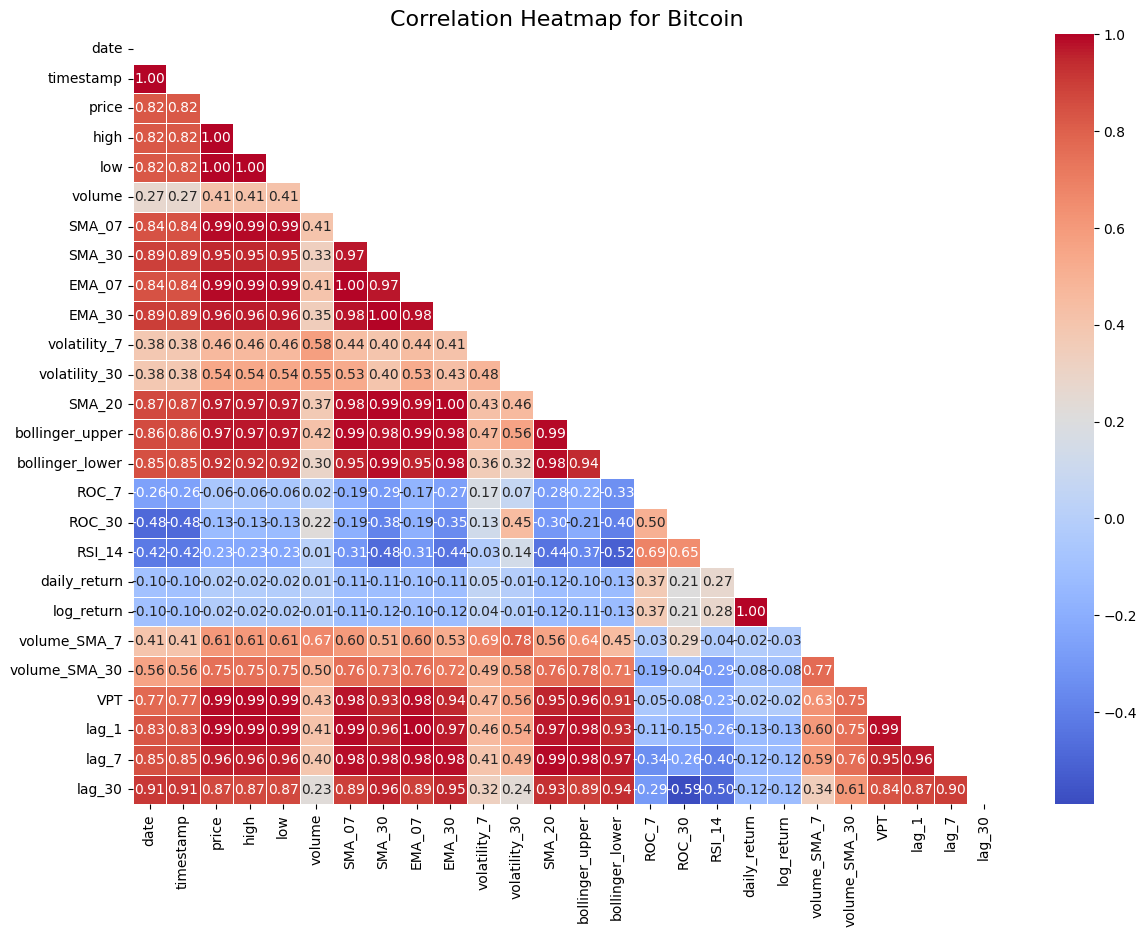

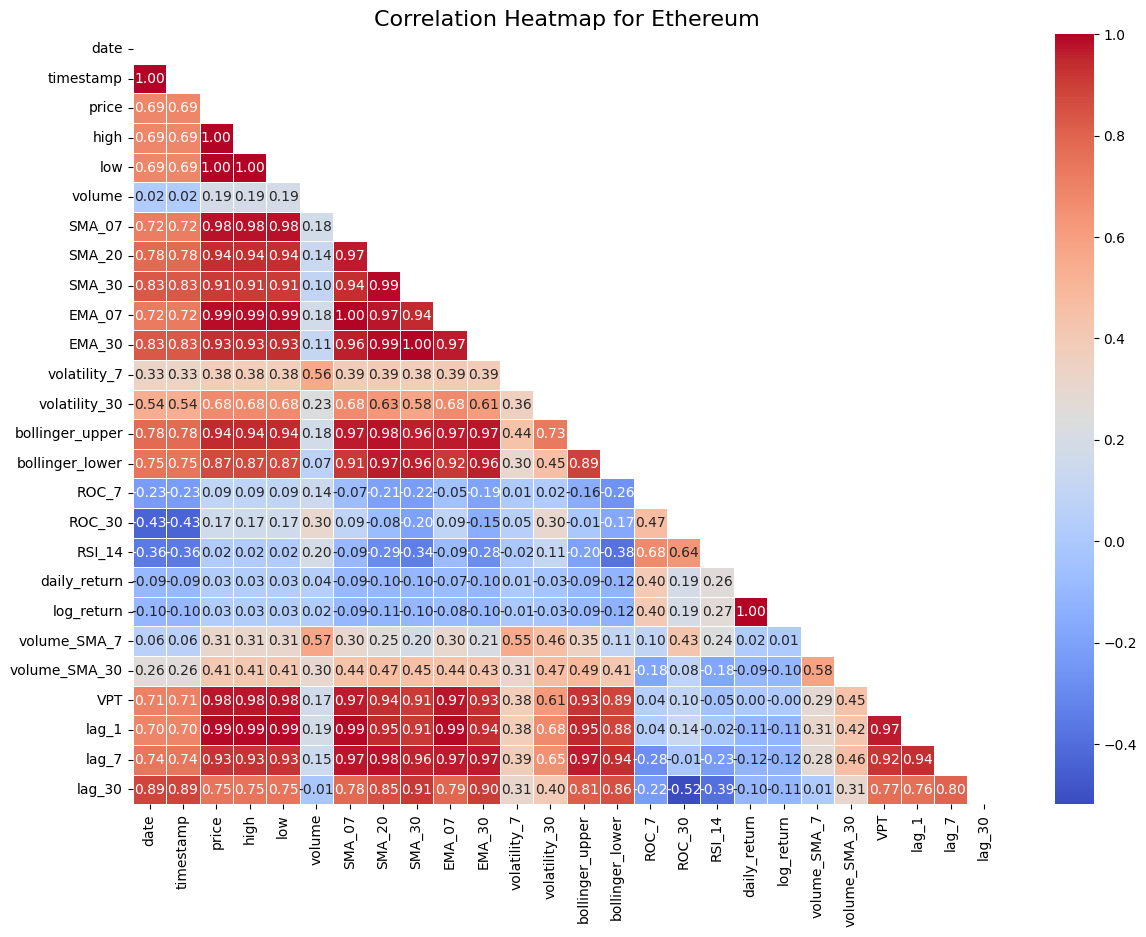

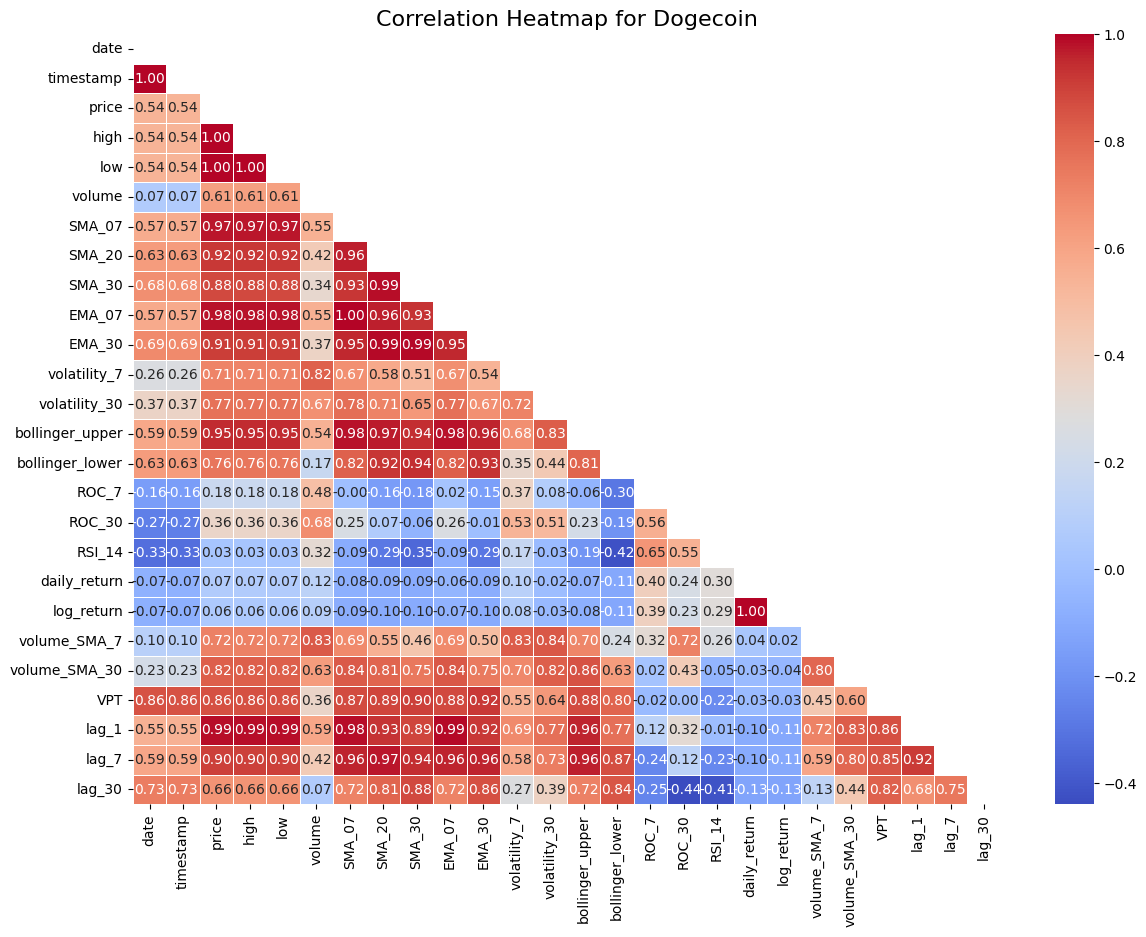

In [67]:
# Plotting a heat map
def plot_correlation_heatmap(df, coin_name):
    corr = df.corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(14, 10))

    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 10}, linewidths=0.5)

    plt.title(f'Correlation Heatmap for {coin_name.capitalize()}', fontsize=16)
    plt.show()

# Plotting the heatmaps for each coin
for coin in data:
    plot_correlation_heatmap(data[coin], coin)


In [47]:
### Lets visualize price trents over the time with moving average!

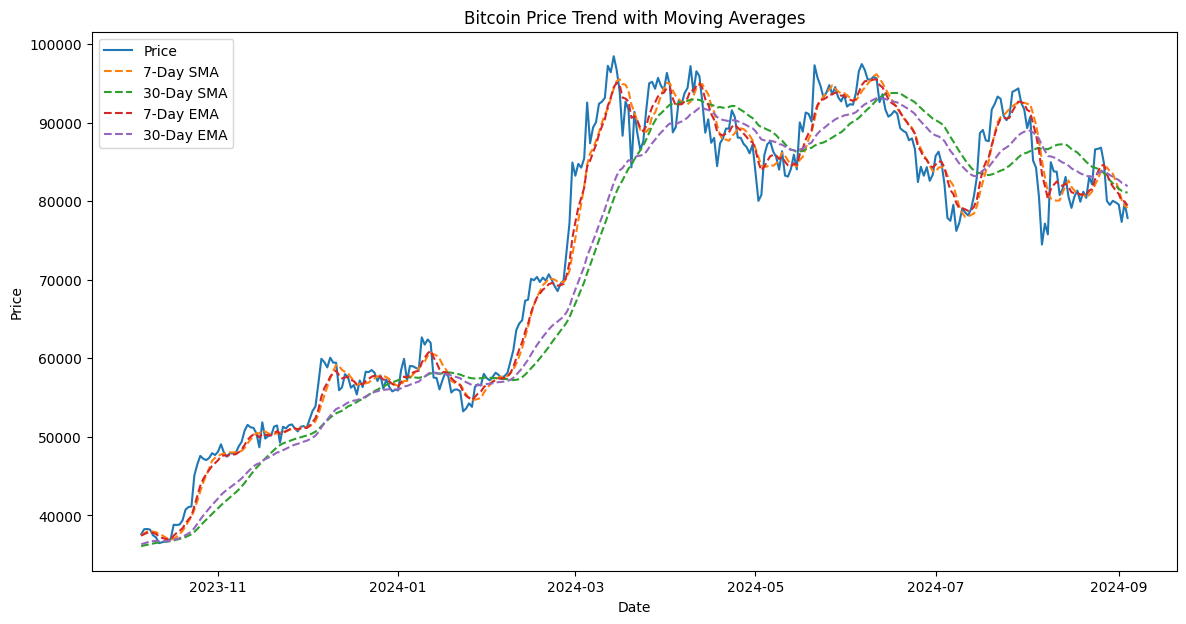

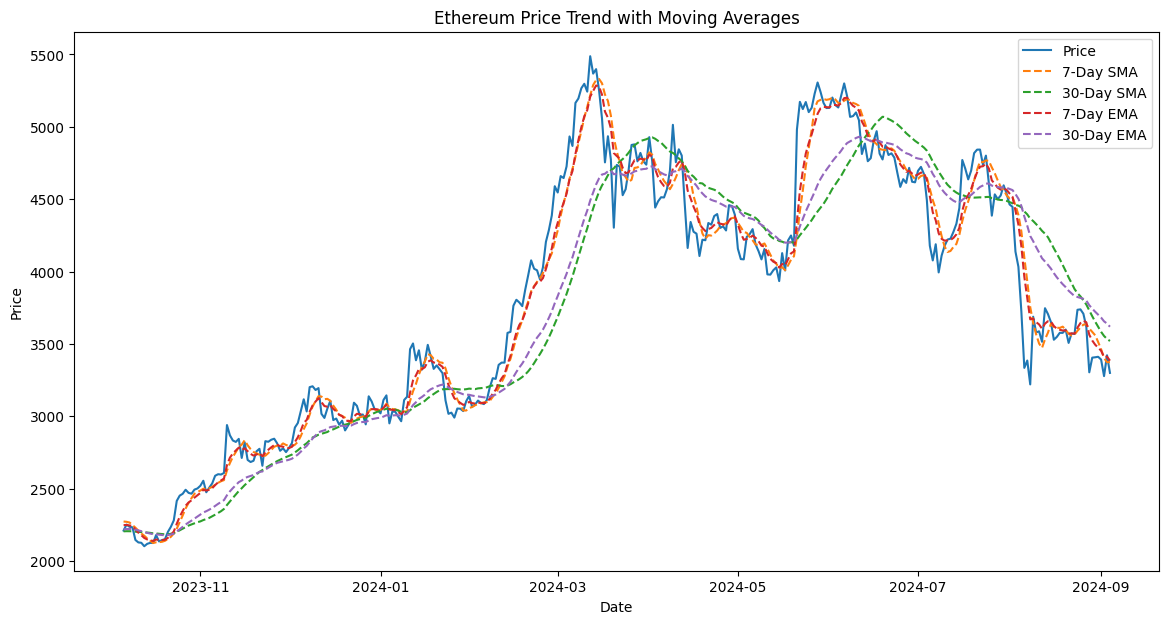

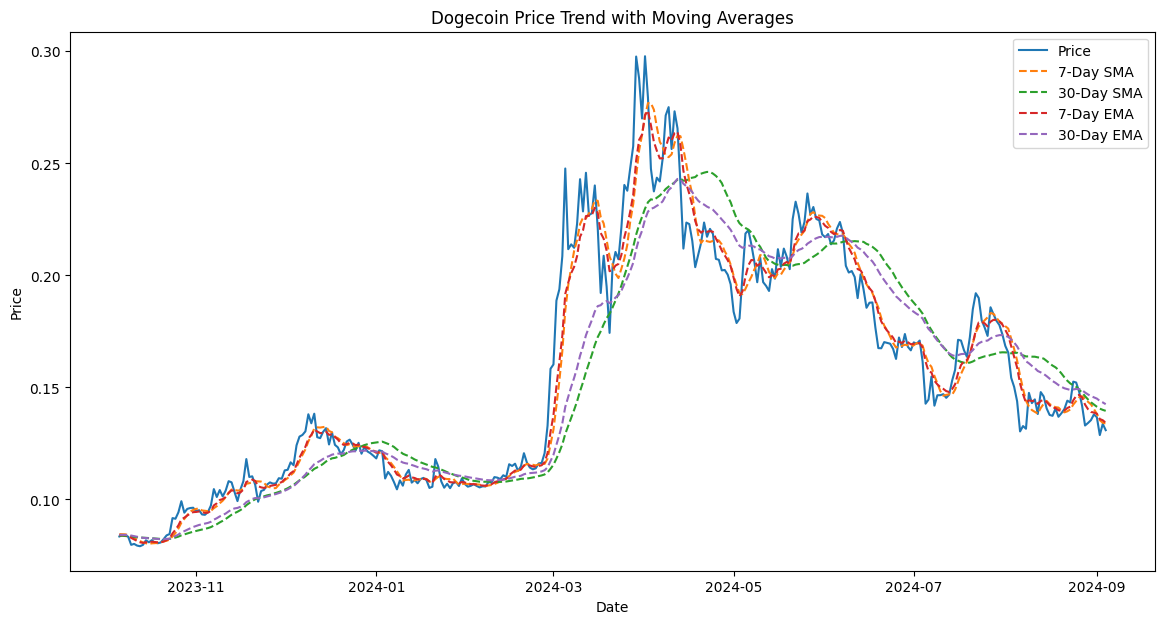

In [70]:
def plot_price_trends(data, coin):

    
    plt.figure(figsize=(14, 7))
    plt.plot(data['date'], data['price'], label='Price')
    plt.plot(data['date'], data['SMA_07'], label='7-Day SMA', linestyle='--')
    plt.plot(data['date'], data['SMA_30'], label='30-Day SMA', linestyle='--')
    plt.plot(data['date'], data['EMA_07'], label='7-Day EMA', linestyle='--')
    plt.plot(data['date'], data['EMA_30'], label='30-Day EMA', linestyle='--')
    plt.title(f'{coin.capitalize()} Price Trend with Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

for coin in data:
    plot_price_trends(data[coin], coin)


In [61]:
### Now price vs Volitality

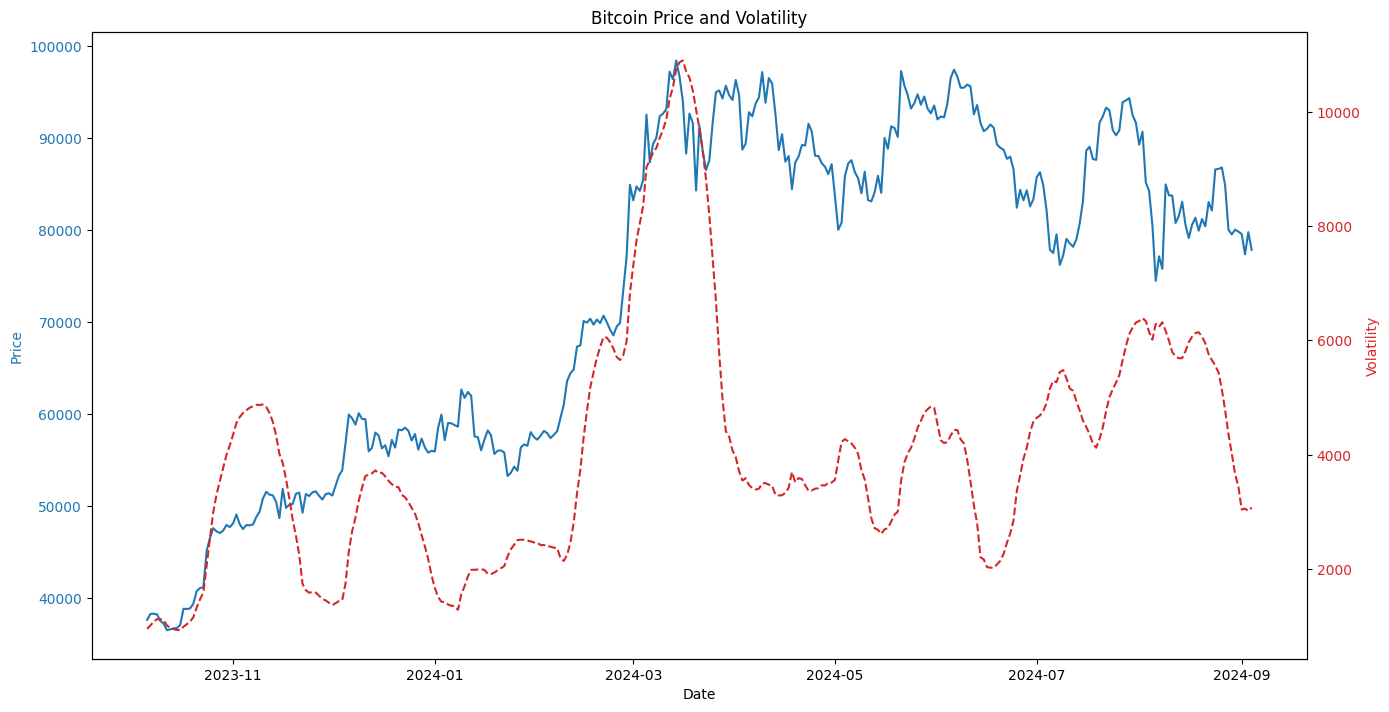

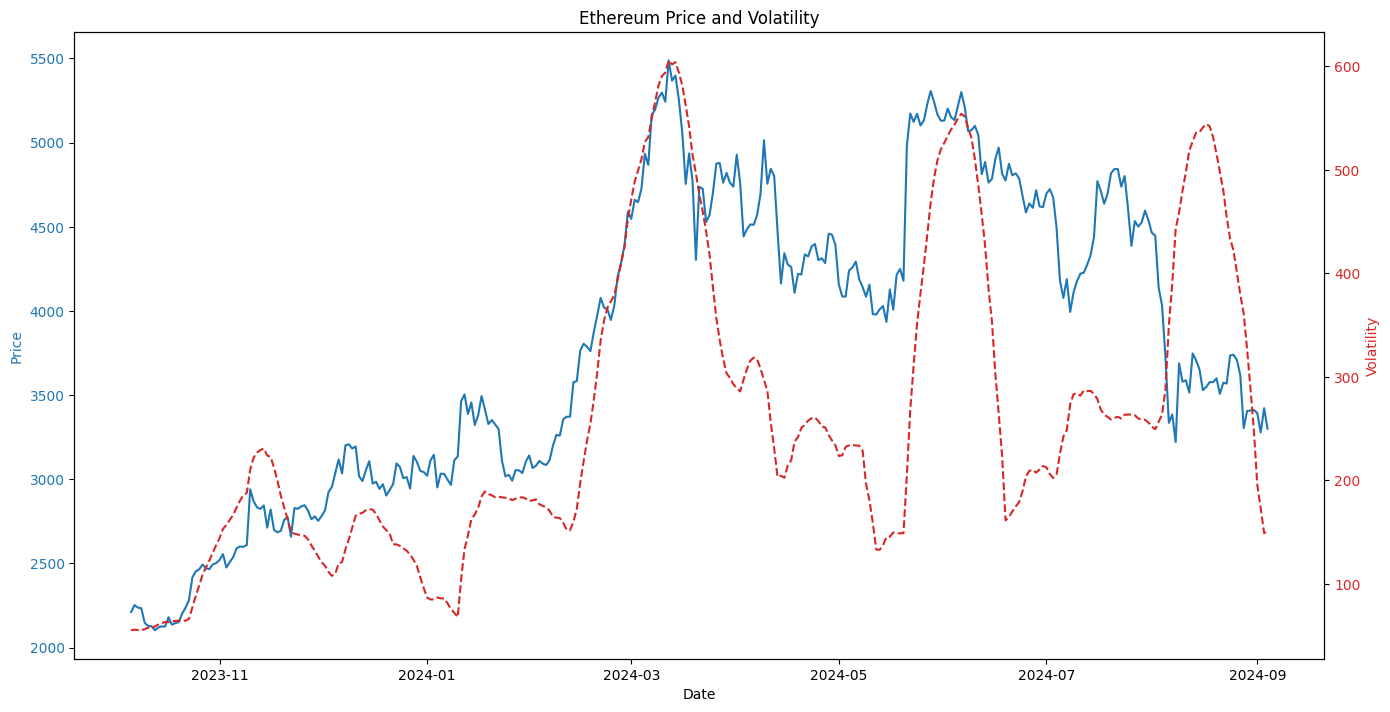

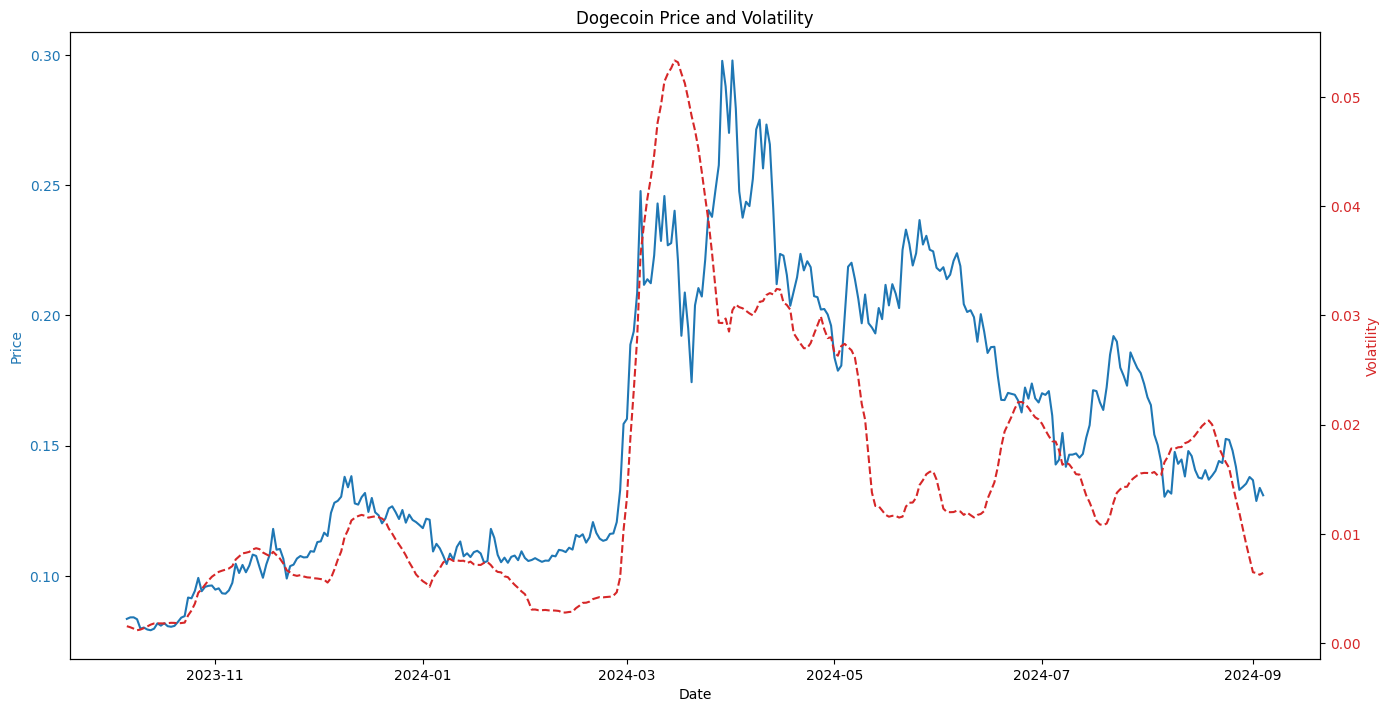

In [71]:
for coin in data:
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='tab:blue')
    ax1.plot(data[coin]['date'], data[coin]['price'], label='Price', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Volatility', color='tab:red')
    ax2.plot(data[coin]['date'], data[coin]['volatility_30'], label='30-Day Volatility', color='tab:red', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()
    plt.title(f'{coin.capitalize()} Price and Volatility')
    plt.show()


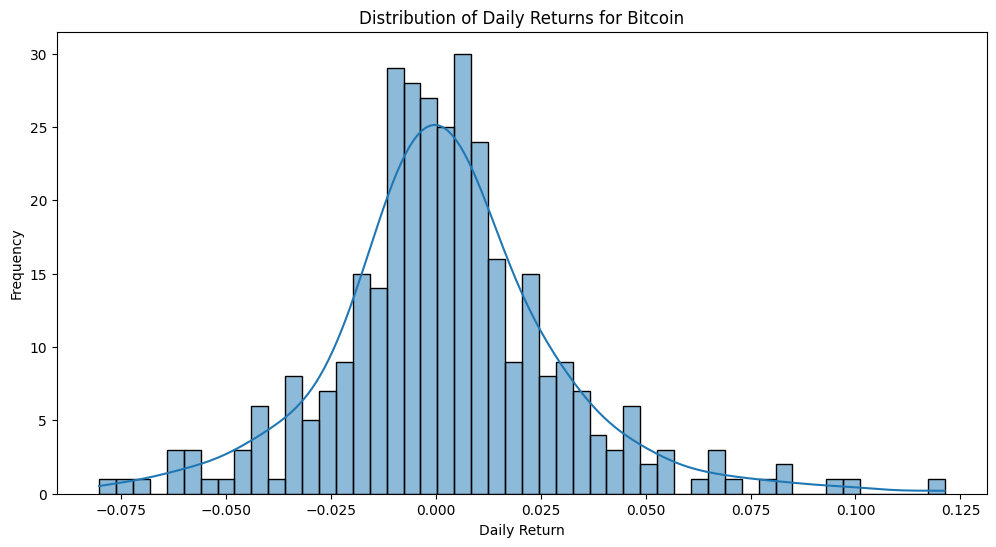

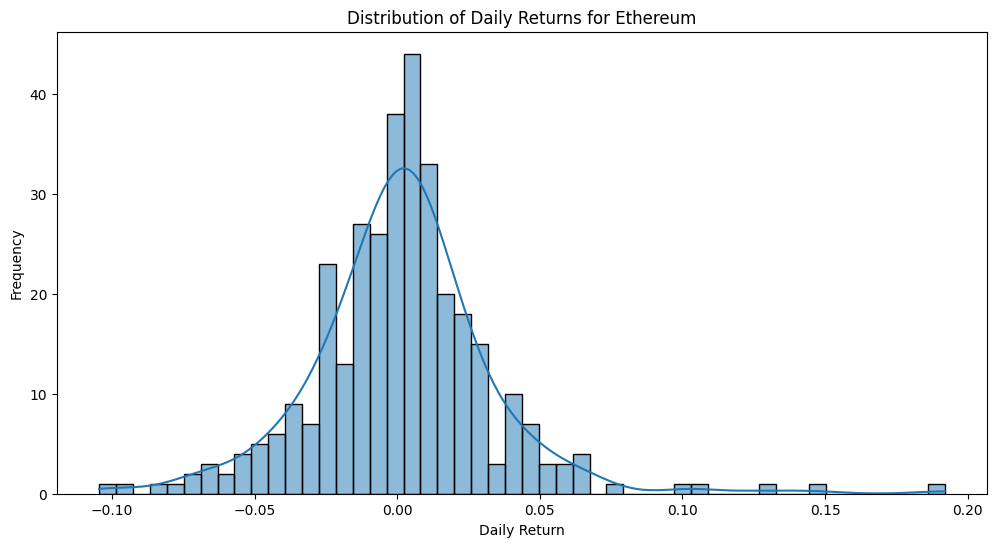

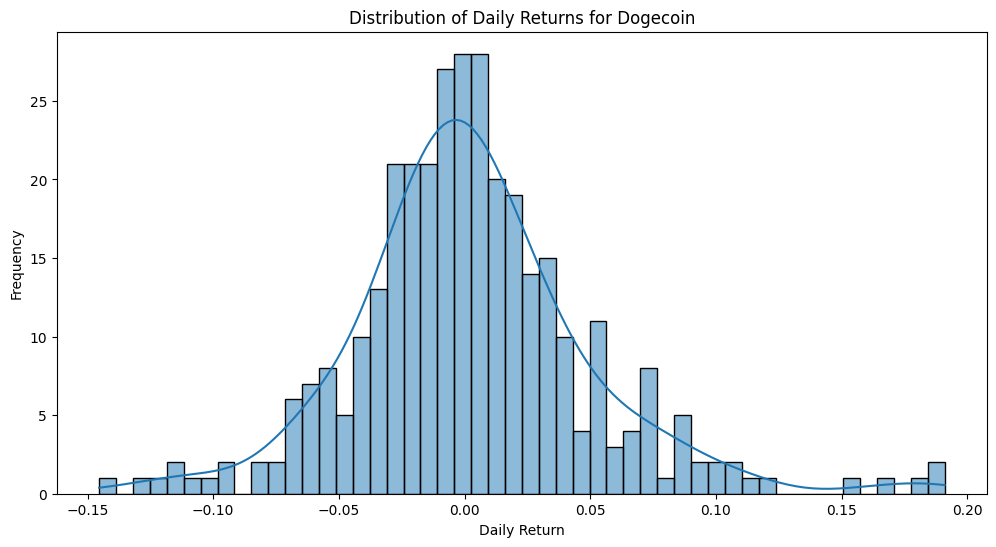

In [72]:
# Plot histogram of daily returns

for coin in data:
    plt.figure(figsize=(12, 6))
    sns.histplot(data[coin]['daily_return'].dropna(), bins=50, kde=True)
    plt.title(f'Distribution of Daily Returns for {coin.capitalize()}')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.show()

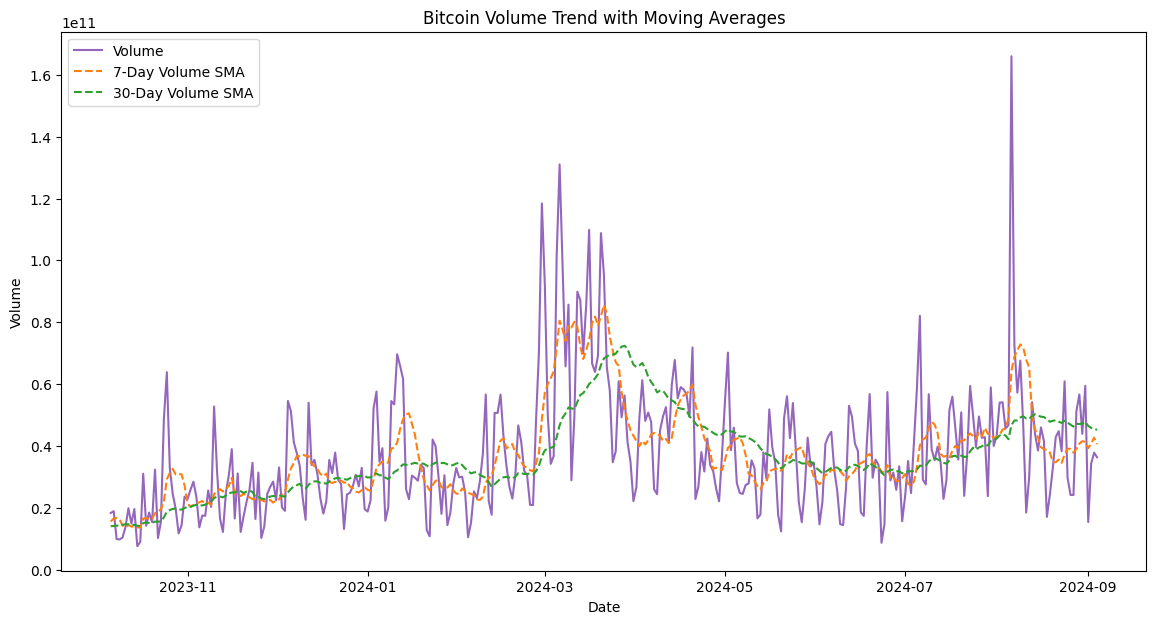

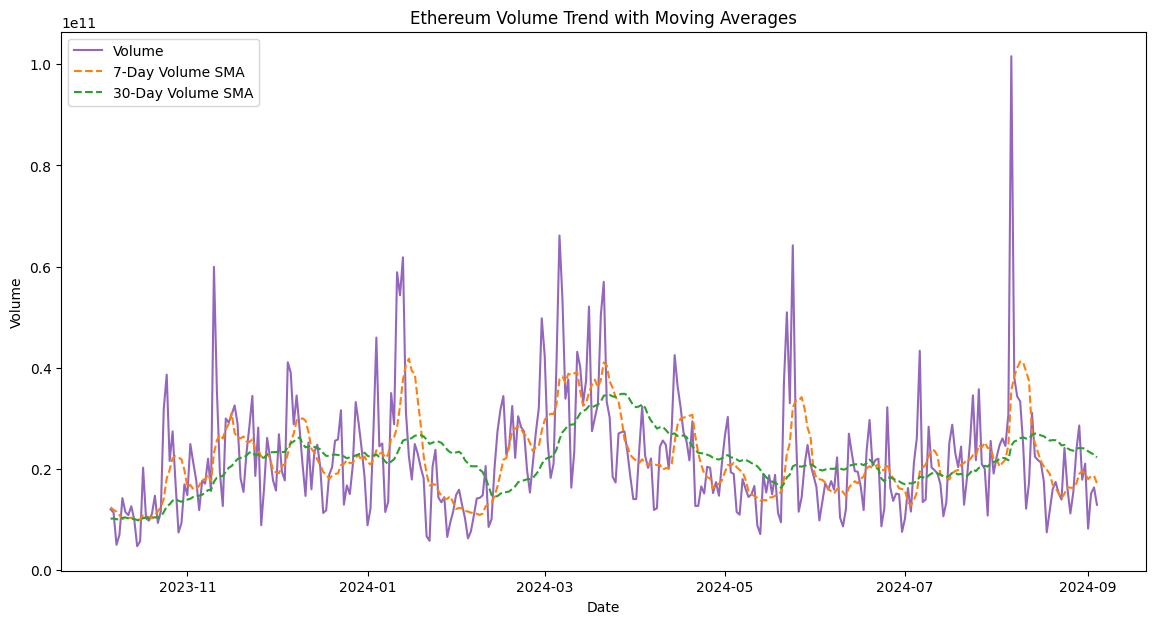

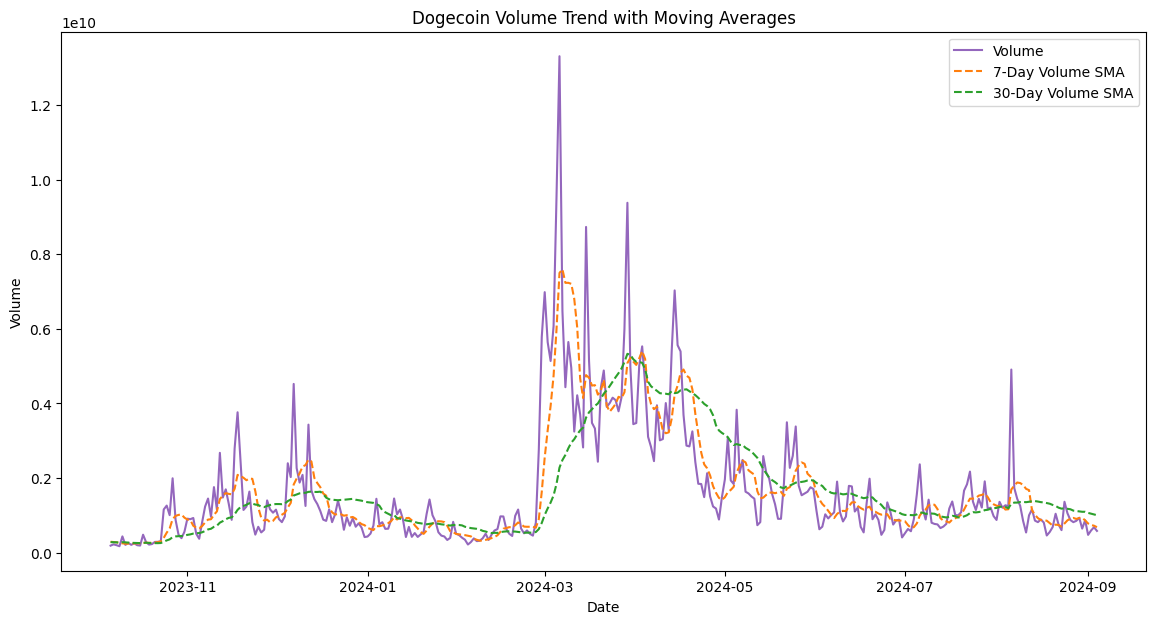

In [73]:
# Plot volume trends
for coin in data:
    plt.figure(figsize=(14, 7))
    plt.plot(data[coin]['date'], data[coin]['volume'], label='Volume', color='tab:purple')
    plt.plot(data[coin]['date'], data[coin]['volume_SMA_7'], label='7-Day Volume SMA', linestyle='--', color='tab:orange')
    plt.plot(data[coin]['date'], data[coin]['volume_SMA_30'], label='30-Day Volume SMA', linestyle='--', color='tab:green')
    plt.title(f'{coin.capitalize()} Volume Trend with Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.show()


### READINGS

In [74]:
# the price, high, and low features are highly correlated with each other for all three cryptocurrencies

# The SMAs and EMAs for each coin show high correlations with the price, which is expected since they are derived directly from it.
    
# There is a noticeable negative correlation between volatility and price for each coin. This suggests that periods of high volatility might correspond to declining prices, though the strength of this relationship can vary.
    
# The lag features show a strong correlation with the current price and moving averages

In [75]:
# The 7-day and 30-day SMAs and EMAs provide smooth trend lines that follow the price closely.

# Points where the 7-day averages cross the 30-day averages can be significant as potential buy/sell signals, typically used in trading strategies.

In [76]:
# Volatility tends to peak during major price movements, particularly noticeable during price spikes.

# In many cases, after a period of high volatility, a downward trend in price is observed, indicating potential market corrections or sell-offs following the volatile period.

In [77]:
# The histograms of daily returns for all three cryptocurrencies exhibit some skewness and kurtosis, indicating that the returns are not perfectly normally distributed.
    
# Bitcoin and Ethereum have more symmetrical distributions of returns, whereas Dogecoin shows a more significant positive skew, indicating a higher probability of extreme positive returns, but also more volatility.

In [78]:
# There are noticeable spikes in volume that correspond with major price movements in all three coins.

In [80]:
#### DROPPING CERTAIN FEATURES AFTER CAREFUL CONSIDERATION

columns_to_drop = [
    'high', 'low',          # Highly correlated with price
    'lag_1', 'lag_7', 'lag_30',  # Strongly correlated with price
    'bollinger_upper', 'bollinger_lower',  # Redundant with moving averages
    'volume_SMA_7', 'volume_SMA_30',  # Less useful compared to raw volume
    'timestamp'  # Redundant with date
]

# Apply the drop across all datasets
for coin in data:
    data[coin] = data[coin].drop(columns=columns_to_drop)

In [81]:
data['bitcoin']

,date,price,volume,SMA_07,SMA_30,EMA_07,EMA_30,volatility_7,volatility_30,SMA_20,ROC_7,ROC_30,RSI_14,daily_return,log_return,VPT
0,2023-10-06,37609.371281,1.833621e+10,37484.831884,36088.489438,37425.128364,36333.789386,627.292832,958.437161,36455.379756,0.032243,0.069444,69.451058,-0.015461,-0.015582,1.276605e+09
1,2023-10-07,38251.006456,1.890507e+10,37723.287172,36192.634687,37631.597887,36457.480810,537.671417,1018.203418,36570.433900,0.045629,0.088946,72.871158,0.017061,0.016917,1.599136e+09
2,2023-10-08,38283.071635,9.887997e+09,37956.095952,36273.873381,37794.466324,36575.260863,295.484255,1084.643994,36691.264777,0.044461,0.067990,73.023029,0.000838,0.000838,1.607425e+09
3,2023-10-09,38199.328331,9.761101e+09,37989.567340,36367.844122,37895.681826,36680.039409,309.598001,1125.885793,36797.792404,0.006171,0.079681,78.840698,-0.002187,-0.002190,1.586072e+09
4,2023-10-10,37479.613847,1.037717e+10,37948.701838,36438.380467,37791.664831,36731.624857,359.012351,1127.081316,36842.200838,-0.007575,0.059838,68.870734,-0.018841,-0.019021,1.390556e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,2024-08-31,79846.143088,5.944096e+10,82545.304143,81967.612182,81372.146427,82913.512474,3401.607893,3441.705439,81917.555520,-0.078040,-0.105923,48.145154,-0.002652,-0.002655,3.511570e+10
331,2024-09-01,79581.579333,1.538592e+10,81532.227458,81596.489135,80924.504654,82698.549045,2999.616084,3043.106436,81857.283413,-0.081819,-0.122732,45.561120,-0.003313,-0.003319,3.506472e+10
332,2024-09-02,77378.427003,3.435440e+10,80182.113731,81336.439976,80037.985241,82355.315365,2251.755829,3059.619324,81647.979243,-0.108843,-0.091588,43.838442,-0.027684,-0.028075,3.411365e+10
333,2024-09-03,79790.286724,3.781417e+10,79461.656211,81186.848016,79976.060612,82189.829646,940.500375,3020.293750,81482.734319,-0.059448,-0.053249,46.757772,0.031170,0.030694,3.529230e+10
